In [3]:
#import speckle
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter

import pyCHX
from pyCHX.chx_packages import *
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *

from collections.abc import Iterable
from collections import defaultdict
from datetime import datetime
import pandas
import re
import warnings
import time
import humanize
import jinja2
import os
import shutil
from types import SimpleNamespace
import tzlocal
import xarray
import event_model
import intake
import pymongo
# Toolz and CyToolz have identical APIs -- same test suite, docstrings.
try:
    from cytoolz.dicttoolz import merge
except ImportError:
    from toolz.dicttoolz import merge

%matplotlib inline

from tiled.client import from_profile
c = from_profile("chx", "dask")

from databroker.queries import TimeRange

# Let's look at just some recent Runs.
results = c.search(TimeRange(since="2021-08"))
#results

OBJECT CACHE: Will use up to 121_695_745_228 bytes (15% of total physical RAM)
/srv/conda/envs/notebook/lib/python3.7/site-packages/databroker/v1.py:72: UserWarning: In databroker 2.x, there are separate notions of 'server' and 'client', and register_handler(...) has no effect on the client. Likely this is being done for you on the server side, so you should not worry about this message unless you encounter trouble loading large array data.
  "In databroker 2.x, there are separate notions of 'server' and 'client', "
OBJECT CACHE: Will use up to 121_695_745_228 bytes (15% of total physical RAM)


In [140]:
startid = 56773
start=[800,1050]
size=[250,150]
roi_start=[0,0] # already dropped the frames
roi_size=[1,1] 
m = 1000

In [141]:
def load_frames(firstscanid,iterations,start,size):
    #image naming
    bucket = []
    idler = []
    starttime = time.time()
    for i in range(iterations):
        if (i%25 == 0):
            currenttime = time.time()
            print("Loading frame "+str(i)+"/"+str(iterations-1)+", time has been "+str(currenttime-starttime)+" sec")
            
        det_name = 'eiger4m_single_image'
        b_uid = firstscanid+2*i
        i_uid = firstscanid+2*i+1
        img_bload = results[b_uid]['primary'].read()
        img_b = np.array(img_bload[det_name][0])
        img_broi = img_b[0,start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
        img_iload = results[i_uid]['primary'].read()
        img_i = np.array(img_iload[det_name][0])
        img_iroi = img_i[0,start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
        bucket.append(img_broi)
        idler.append(img_iroi)
    return np.array(bucket), np.array(idler)

def read_roi(frame,start,size):
    output = frame[start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
    return output

def read_roi_m(bucket,idler,start,size):
    for i in range(bucket.shape[0]):
        bucket_roi[i] = bucket[i,start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
        idler_roi[i] = idler[i,start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
    return bucket_roi, idler_roi

In [142]:
bucket,idler = load_frames(startid,m,start,size)

Loading frame 0/999, time has been 5.7220458984375e-06 sec
Loading frame 25/999, time has been 38.31272530555725 sec
Loading frame 50/999, time has been 75.90818238258362 sec
Loading frame 75/999, time has been 113.94124388694763 sec
Loading frame 100/999, time has been 151.6668610572815 sec
Loading frame 125/999, time has been 195.6851725578308 sec
Loading frame 150/999, time has been 240.69665026664734 sec
Loading frame 175/999, time has been 284.69263339042664 sec
Loading frame 200/999, time has been 329.1533236503601 sec
Loading frame 225/999, time has been 373.7951850891113 sec
Loading frame 250/999, time has been 417.30436539649963 sec
Loading frame 275/999, time has been 461.1428654193878 sec
Loading frame 300/999, time has been 503.1697862148285 sec
Loading frame 325/999, time has been 546.3891570568085 sec
Loading frame 350/999, time has been 589.2303206920624 sec
Loading frame 375/999, time has been 631.7862086296082 sec
Loading frame 400/999, time has been 674.1859970092773 

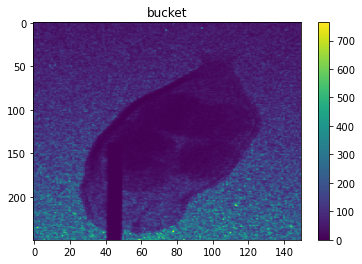

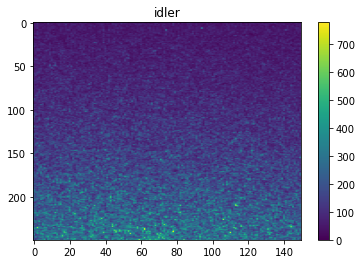

Text(0.5, 1.0, 'idler-bucket!')

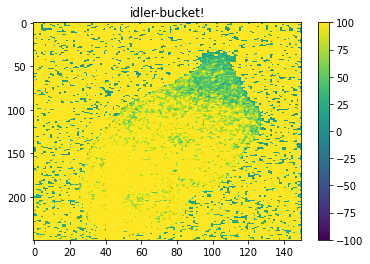

In [6]:
bucket.shape

plt.figure()
plt.subplot()
plt.imshow(bucket[0], vmin = 0, vmax = np.max(bucket[0]),aspect = 'auto')
plt.colorbar()
plt.title("bucket")
plt.show()
plt.subplot()
plt.imshow(idler[0], vmin = 0, vmax = np.max(idler[0]),aspect = 'auto')
plt.colorbar()
plt.title("idler")
plt.show()
plt.subplot()
plt.imshow(idler[0]-bucket[0], vmin = -100, vmax = 100,aspect = 'auto')
plt.colorbar()
plt.title("idler-bucket!")

In [7]:
def dgi(ghost, binsize, data):
    #ghost - output
    #binsize - how many frames to do correlation on
    #data - array of input and output data
    
    bucket = data[0]
    idler = data[1]
    
    #np.array(bucket)
    img_sum = np.array(data[0]).sum(1).sum(1)
    img_int = np.array(data[1]).sum(1).sum(1)
    print(img_sum.shape)
    
    avg = np.mean(img_sum)
    int_avg = np.mean(img_int)
    
    for i in range(ghost.shape[0]):
        for j in range(ghost.shape[1]):
            sum = 0
    
            for bin in range(binsize):
                sum += (img_sum[bin] - avg*img_int[bin]/int_avg)*idler[bin,i,j]
        
            ghost[i,j]=sum/binsize
            
def gi3(bin_size, ghost, img_sum, img_mp, img_int):
    # bin_size = m, the number of frames
    # ghost, the output array holding the ghost image
    # img_sum = sum of bucket
    # img_mp = idlers
    # img_int = sum of idler
    avg = np.mean(img_sum)
    int_avg = np.mean(img_int)
    
    #print(img_sum.shape)
    
    for i in range(ghost.shape[0]):
        for j in range(ghost.shape[1]):
            sum = 0
    
            for bin in range(bin_size):
                sum += (img_sum[bin] - avg*img_int[bin]/int_avg)*img_mp[bin][i][j]
                  
            ghost[i,j]=sum/bin_size 

In [49]:
roi_start=[0,0] # already dropped the frames
roi_size=[250,150] # 250x150 max
roi_step=[250,150]
bucket_roi = np.zeros((m, roi_size[0], roi_size[1]))
idler_roi = np.zeros((m, roi_size[0], roi_size[1]))

bucket_roi,idler_roi = read_roi_m(bucket,idler,roi_start,roi_size)

In [50]:
bucket_roi.shape

(1000, 250, 150)

In [51]:
bucket_roi,idler_roi = read_roi_m(bucket,idler,roi_start,roi_size)
bucket_roi.shape

(1000, 250, 150)

In [52]:
x = range(0,size[1]-roi_size[1]+1,roi_step[1])
y = range(0,size[0]-roi_size[0]+1,roi_step[0])
total = int((((max(y)-min(y))/roi_step[0])+1)*(((max(x)-min(x))/roi_step[1])+1))
map = np.zeros([total,roi_size[0],roi_size[1]])
ghost = np.zeros(roi_size)
ghost_total = np.zeros([size[0], size[1]])
ghost_conts = np.zeros([size[0], size[1]])

img_size = roi_size[0]*roi_size[1]

# img_sum = np.zeros([m])
# for j in range(m):
#    img_sum[j] = np.sum(bucket[j]) / img_size
    
i = 0
starttime = time.time()
for startx in x:
    for starty in y:
        roi_start = [starty, startx]
        
        bucket_roi,idler_roi = read_roi_m(bucket,idler,roi_start,roi_size)
        data = bucket_roi, idler_roi
        
        img_sum = np.zeros([m])
        img_int = np.zeros([m])
        for j in range(m):
            img_sum[j] = np.sum(bucket_roi[j]) 
            img_int[j] = np.sum(idler_roi[j]) / img_size
        
        ghost = np.zeros(roi_size)
        # dgi(ghost, m, data)
        gi3(m, ghost, img_sum, idler_roi, img_int)
        i += 1
        
        xpos = 0;
        for ghost_x in range(startx, startx + roi_size[1]):
            ypos = 0
            for ghost_y in range(starty, starty + roi_size[0]):
                ghost_total[ghost_y,ghost_x] += ghost[ypos,xpos]
                ghost_conts[ghost_y,ghost_x] += 1
                ypos += 1
            xpos += 1 
            
        if i%100==0:
            currenttime = time.time()
            timedif = currenttime-starttime
            currentpercent = i/total
            totaltime = timedif/currentpercent
            timeleft = (totaltime-timedif)/60
            print("i="+str(i)+"/"+str(total)+", "+str(currentpercent)+" complete, est. time left ~" + str(timeleft))
            
print("Done!")

Done!


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


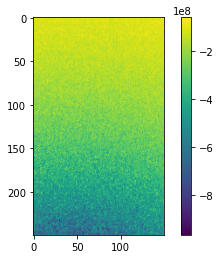

In [53]:
#plt.imshow(ghost_conts)
#plt.colorbar()
plt.imshow(np.divide(ghost_total,ghost_conts))
plt.colorbar()
print(ghost_conts)

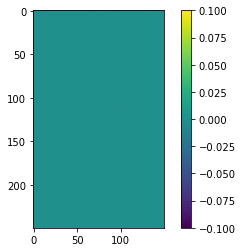

In [46]:
bucket_sum = np.zeros([size[0], size[1]])
idler_sum = np.zeros([size[0], size[1]])
sdoti = np.zeros([size[0], size[1]])
idoti = np.zeros([size[0], size[1]])
gi_1by1 = np.zeros([size[0], size[1]])


for j in range(m):
    sdoti += bucket[j]*idler[j]
    bucket_sum += bucket[j]
    idler_sum += idler[j]
    idoti += idler[j]*idler[j]

gi_1by1 = (1/m)*sdoti - (1/m)*np.multiply(np.divide(bucket_sum,idler_sum),idoti)
    
plt.imshow(0-np.divide(ghost_total,ghost_conts))
plt.colorbar()

In [28]:
np.array(bucket).sum(0).sum(0)

array([277401906, 277396962, 277480926, 277935331, 277470790, 278402683,
       278428104, 278898101, 278767773, 279515618, 280250563, 280244801,
       279936915, 280727293, 281085971, 281282756, 281183168, 281071234,
       281843963, 282060285, 282305727, 282935361, 283114051, 283715849,
       283266100, 282610691, 271900586, 255366163, 240997521, 214338213,
       201929048, 196810609, 188264311, 181687129, 177769006, 173366489,
       168981824, 167433117, 171041360, 169785198, 161217500,  87839525,
        78924680,  76908105,  75987553,  74041932,  71734312,  69269066,
        67149109,  94724931, 142201019, 141341778, 136662953, 132610064,
       126552858, 124195975, 122636947, 121580760, 119378570, 119171882,
       119866826, 118684060, 118347488, 118737493, 118579149, 118039069,
       117920069, 118366842, 120484691, 122415188, 124300201, 126136604,
       128446295, 129317886, 130783142, 130910506, 129979829, 129746457,
       130211945, 133245826, 136516286, 134120274, 

In [189]:
bucket_roi.shape

(1000, 1, 1)

In [71]:
np.array(bucket).sum(1).sum(1)

array([ 3614318,  3945692,  4387599,  5298884,  5897583,  6414955,
        6998498,  7573718,  7557948,  9137463, 10751155, 11481895,
       10280784, 13409940, 14339753, 15352658, 16240719, 17331736,
       18406839, 19112249, 28894537, 29637395, 28817519, 29472484,
       16099346, 29302549, 29122013, 29529018, 29039226, 29854537,
       30044040, 29922899, 29742780, 29434422, 29853721, 29468084,
       28942762, 29288083, 29407973, 29407727, 28902432, 29381166,
       29702365, 29556987, 30159816, 29743403, 29192300, 29895766,
       29749674, 29259642, 29593010, 29593461, 29679224, 29482495,
       29747380, 29342171, 29275751, 29189103, 29513323, 29281152,
       29268769, 29683134, 29957975, 29271557, 30028757, 29522188,
       29046426, 29475816, 29468441, 29613472, 29178396, 29542366,
       29364802, 29166526, 22791506, 29932029, 30226532, 29945919,
       30036607, 29786460, 29546055, 29685549, 29658222, 29665782,
       29823080, 29188579, 29280955, 17326822, 29218551, 29052

In [73]:
np.sum(bucket[999]) 

30066429

In [178]:
with open('seed-56773.npy', 'wb') as f:
    np.save(f, bucket)
    np.save(f, idler)

In [179]:
np.savetxt('seed-56773_bucket_1200frames.txt', bucket, delimiter=',')

ValueError: Expected 1D or 2D array, got 3D array instead

In [184]:
with open('seed-56773_bucket_1200frames.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(bucket.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in bucket:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, delimiter=',')

        # Writing out a break to indicate different slices...
        outfile.write('# New frame\n')

In [185]:
with open('seed-56773_idler_1200frames.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(idler.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in idler:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, delimiter=',')

        # Writing out a break to indicate different slices...
        outfile.write('# New frame\n')